# _Redes neuronales artificiales_

### Importaciones

In [262]:
import random
import numpy as np
import copy
import utils
from math import e 

### Visión general de la implemetación
Se definen las clases **Neuron** y **ANN** las cuales representan de forma general a las neuronas y a la red neuronal a entrenear respectivamente. <br>
Dados estos modelos, un objeto de tipo ANN se asocia a varios objetos de tipo Neuron. <br>
Dicha asociación se da a través de dos listas de neuronas que contiene la clase ANN, una lista representando a la capa oculta y la restante a la capa de salida. <br>
Adicionalmente el objeto ANN recibe como parámetro el número de neuronas que debe implementar en cada capa. <br>
Dada esta arquitectura, solo es posible construir redes con una única capa oculta pero con capas de distinto tamaño. 

### Clase Neuron
***
#### Métodos
- **init(n_inputs)**: Inicializa n_inputs pesos de la neurona con valores entre -0.5 y 0.5 de forma aleatoria.
- **compute_input(inputs)**: Calcula la combinación lineal entre los pesos y los valores de las inputs.
- **apply_sigmoid(computed_value)**: Aplica la función de sigmoide a computed_value y almacena el valor de salida.
- **calculate_output_neuron_error(expected)**: Aplica la formula de error para una neurona de la capa de salida y almacena el resultado. 
- **calculate_hidden_neuron_error(output_layer, index)**: Aplica la formula de error para una neurona de la capa de oculta y almacena el resultado.
- **update_weights(rate, inputs)**: Actualiza todos los pesos de la neurona incluyendo el peso $w_{0}$ para el cual se asume una entrada de valor 1.

#### Observaciones
- Se asume que el valor $w_{0}$ es el último en la lista de pesos para mayor facilidad a la hora de implemetación.


In [263]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = [round(random.uniform(-0.5,0.5),5) for i in range(n_inputs)]
        self.output = None
        self.error = None

    def compute_input(self, inputs):
        result = self.weights[-1]
        for i in range(len(self.weights)-1):
            result += self.weights[i] * inputs[i]
        self.output = result     
        return result
    
    def apply_sigmoid(self, computed_value):
        self.output = 1 / (1 + e**(-computed_value)) 
        return self.output
    
    def calculate_output_neuron_error(self, expected):
#         self.error = self.output * (1.0 - self.output) * (expected - self.output) 
        self.error = expected - self.output
        return  self.error
    
    def calculate_hidden_neuron_error(self, output_layer, index):
        self.error = 0.00000
        for neuron in output_layer:
            self.error += neuron.error * neuron.weights[index]
        self.error *= self.output * (1.0 - self.output)
        return self.error
    
    def update_weights(self, rate, inputs):
        for i in range(len(inputs)):
            self.weights[i] += rate * self.error * inputs[i]
        self.weights[-1] += rate * self.error  
    

### Clase ANN
***
#### Métodos
- **init(n_inputs, n_hidden, n_outputs)**: Inicializa las neuronas de la capa oculta y la capa de salida. Para la capa oculta se crean n_hidden neuronas cada una de las cuales tiene (n_inputs + 1) pesos, uno por cada columna en el conjunto de datos más el adicional por el peso $w_{0}$. Adicionalmente se crean n_outputs neuronas para la capa de salida, cada una con (n_hidden + 1) pesos. Esto significa que cada neurona en la capa de salida se conecta con cada neurona de la capa oculta.
- **forward_propagate(instance)**: Recibe en instance una instancia a clasificar, procesa la misma con cada neurona de la capa oculta, luego cada salida generada por las neuronas de la capa oculta son procesadas por cada una de las neuronas de la capa de salida, devolviendo finalmente el resultado de la clasificación.
- **update_weights(instance)**: Actualiza todos los pesos presentes en la red. Recibe la última instancia procesada como parámetro ya que son las inputs necesarias para actualizar pesos de la capa oculta. 

#### Observaciones
- La función de activación para las neuronas de la capa oculta es la función sigmoide, no así para las neuronas de la capa de salida, las cuales son representadas como unidades lineales para no acotar los resultados de la red a [0,1] 

In [264]:
class ANN:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.hidden_layer = [Neuron(n_inputs + 1) for i in range(n_hidden)]
        self.output_layer = [Neuron(n_hidden + 1) for i in range(n_outputs)]

    def forward_propagate(self, instance):
        
        inputs = instance
        hidden_layer_outputs = []
        for neuron in self.hidden_layer:
            computed_input = neuron.compute_input(inputs)
            neuron_output = neuron.apply_sigmoid(computed_input)
            hidden_layer_outputs.append(neuron_output)
        
        inputs = hidden_layer_outputs
        final_outputs = []
        for neuron in self.output_layer:
            computed_input = neuron.compute_input(inputs)
            final_outputs.append(computed_input)        
        
        return final_outputs
    
    def update_weights(self, instance, rate):
        
        output_layer_inputs = []
        for neuron in self.hidden_layer:
            neuron.update_weights(rate, instance)
            output_layer_inputs.append(neuron.output)
        
        for neuron in self.output_layer:
            neuron.update_weights(rate, output_layer_inputs)

### Parte a) <br>
### Algoritmo Backpropagation

In [265]:
def backpropagation(n_inputs, n_hidden, n_outputs, max_iter, data_set, rate):
    
    # Crea la red neuronal artificial.     
    neural_network = ANN(n_inputs, n_hidden, n_outputs)
    
    versions = []
    
    iterations_errors = []
    
    for iter in range (max_iter):
                
        iteration_error = 0.00000

        # Se recorre el conjunto de entrenamiento.
        # instance: ejemplo leído.
        # expected: target value del ejemplo.
        for (instance, expected) in data_set:

            # Se clasifica la instancia.             
            output = neural_network.forward_propagate(instance)
            
            # Se recorren las neuronas de la capa de salida.             
            for index, neuron in enumerate(neural_network.output_layer):
                # Se calcula y almacena el error de cada neurona con respecto a su 
                # componente correspondiente en el vector resultado esperado.                 
                neuron.calculate_output_neuron_error(expected[index])
                                     
            # Se recorren las neuronas de la capa oculta.
            for index, neuron in enumerate(neural_network.hidden_layer):
                # Se calcula y almacena el error para cada neurona.               
                neuron.calculate_hidden_neuron_error(neural_network.output_layer, index)
            
            # Se calcula el error entre entre la salida de la red neuronal y el valor esperado.
            iteration_error += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
            
            # Se actualizan todos los pesos de la red.
            neural_network.update_weights(instance, rate)
        
        iterations_errors.append(iteration_error)

        if (iter == 10 or iter == 100 or iter == 1000 or iter == 10000):
            versions.append(copy.deepcopy(neural_network))

    
    versions.append(neural_network)
    return versions, iterations_errors

### Parte b)

Se definen las funciones de la letra a utilizar junto con los conjuntos de entrenamiento:

In [266]:
def f(x):
    return x**3 - x**2 + 1

def g(x,y):
    return 1 - x**2 - y**2
    
def h(x,y):
    return x + y

training_set_f = [([x],[f(x)])for x in np.random.uniform(-1,1,40)]
training_set_g = [([x,y],[g(x,y)]) for (x,y) in list(zip(np.random.uniform(-1,1,40), np.random.uniform(-1,1,40)))]
training_set_h = [([x,y],[h(x,y)]) for (x,y) in list(zip(np.random.uniform(-1,1,3), np.random.uniform(-1,1,3)))]

- #### Ajustamos a la función f

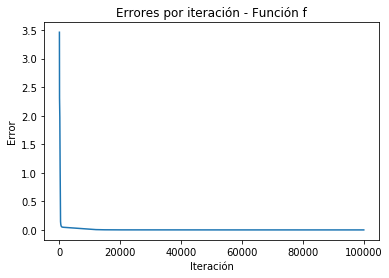

In [274]:
rate = 0.1
iterations = 10**5
n_input = 1
n_hidden = 3
n_output = 1

versions_f, errors_f = backpropagation(n_input,n_hidden,n_output,iterations,training_set_f,rate)

plot_errors('f', errors_f)

- #### Ajustamos a la función g

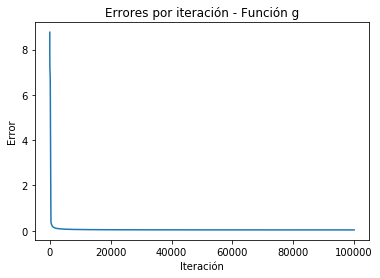

In [275]:
rate = 0.1
iterations = 10**5 
n_input = 2
n_hidden = 3
n_output = 1

versions_g, errors_g = backpropagation(n_input,n_hidden,n_output,iterations,training_set_g,rate)

plot_errors('g', errors_g)

- #### Ajustamos a la función h

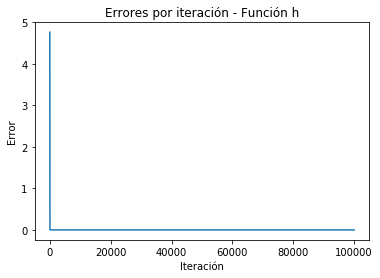

In [276]:
rate = 0.1
iterations = 10**5 
n_input = 2
n_hidden = 3
n_output = 1

versions_h, errors_h = backpropagation(n_input,n_hidden,n_output,iterations,training_set_h,rate)

plot_errors('h', errors_h)

#### Funciones para graficar

In [268]:
def plot_errors(function_name, errors):
    plt.plot(list(range(len(errors))),errors)
    plt.title('Errores por iteración - Función ' + function_name)
    plt.ylabel('Error')
    plt.xlabel('Iteración')
    plt.show()